In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/fulldata.csv")
df.head()

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09


In [2]:
df.describe()

,Score,Num of Comments,Date Created
count,12854.000000,12854.000000,1.285400e+04
mean,118.558270,19.055936,1.622576e+09
std,498.888034,60.381567,6.112838e+07
min,0.000000,0.000000,1.231048e+09
25%,3.000000,1.000000,1.632132e+09
50%,12.000000,3.000000,1.642030e+09
75%,65.000000,15.000000,1.645107e+09
max,25055.000000,2150.000000,1.646272e+09


In [3]:
#Create simple dataframe with only text and predictor
df_simple = df[['Title','Political Lean']] 

#dummy code predictor
df_simple['Political Lean'] = df_simple['Political Lean'].replace('Liberal',1)
df_simple['Political Lean'] = df_simple['Political Lean'].replace('Conservative',0)

df_simple = df_simple.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

C:\Users\Andrew\AppData\Local\Temp\ipykernel_17056\95519498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple['Political Lean'] = df_simple['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_17056\95519498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple['Political Lean'] = df_simple['Political Lean'].replace('Conservative',0)


In [5]:
df_simple['length'] = df_simple['Title'].apply(lambda x: len(x))
df_simple = df_simple[df_simple['length']>=15]

In [6]:
X = df_simple.drop(['y','length'],axis=1)
y = df_simple['y']

In [8]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)

In [9]:
from sklearn.utils import shuffle
X, y = shuffle(X,y, random_state=13)

In [10]:
import string 

def lowercase(text):
    return text.lower()

def unpunctuate(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

def remove_stopwords(tokenized_text):
    ENGstopwords = stopwords.words('english')
    text = [word for word in tokenized_text if word not in ENGstopwords]
    return text

def tokenize(text):
    tokens = text.split()
    return tokens

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer() 

def lemmatize(text):
    lemtext = []
    for word in text: 
        lemword = lemmatizer.lemmatize(word)
        lemtext.append(lemword)
    return lemtext

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
X['Title'] = X['Title'].apply(lowercase)
X['Title'] = X['Title'].apply(unpunctuate)
X['Title'] = X['Title'].apply(tokenize)
# X['Title'] = X['Title'].apply(remove_stopwords)
X['Title'] = X['Title'].apply(lemmatize)

In [12]:
all_words = X['Title'].tolist()

from gensim.models import Word2Vec

word2vec = Word2Vec(all_words)

In [13]:
def get_vector(word_list):
    vector = np.zeros(word2vec.vector_size)  # Create an empty vector of appropriate size
    count = 0  # Initialize a count variable
    for word in word_list:
        if word in word2vec.wv:
            vector += word2vec.wv[word]  # Add the word vector to the overall vector
            count += 1  # Increment the count
    if count != 0:
        vector /= count  # Divide the vector by the count to get the average
    return vector

In [14]:
X['Title'] = X['Title'].apply(get_vector)

In [15]:
# Convert the vector column to a list of lists
vector_list = X['Title'].tolist()

# Convert the list of lists to a NumPy array with float32 data type
vector_array = np.array(vector_list, dtype=np.float32)

word_vectors = word2vec.wv.vectors

In [16]:
print(word_vectors.shape)
print(vector_array.shape)

(4729, 100)
(16300, 100)


In [17]:
from sklearn.model_selection import train_test_split 
import numpy as np
X = X['Title']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.15)

In [18]:
X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 100))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 100))

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

classifier = Sequential()

classifier.add(LSTM(units = 256, return_sequences = True, activation = 'relu', input_shape = (1, 100)))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 256, return_sequences = True, activation = 'relu'))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 128, return_sequences = True, activation = 'relu'))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 64, activation = 'relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 1, activation='sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
classifier.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test,y_test), callbacks = [early_stopping])
                                                                                
y_pred = classifier.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', roc_auc)                                                                              

Epoch 1/100
433/433 [==============================] - 12s 18ms/step - loss: 0.6922 - accuracy: 0.5126 - auc: 0.5203 - val_loss: 0.6928 - val_accuracy: 0.5640 - val_auc: 0.5814
Epoch 2/100
433/433 [==============================] - 7s 17ms/step - loss: 0.6804 - accuracy: 0.5654 - auc: 0.5833 - val_loss: 0.6774 - val_accuracy: 0.5726 - val_auc: 0.6182
Epoch 3/100
433/433 [==============================] - 8s 19ms/step - loss: 0.6748 - accuracy: 0.5670 - auc: 0.5992 - val_loss: 0.6655 - val_accuracy: 0.5853 - val_auc: 0.6297
Epoch 4/100
433/433 [==============================] - 8s 19ms/step - loss: 0.6710 - accuracy: 0.5726 - auc: 0.6101 - val_loss: 0.6634 - val_accuracy: 0.5853 - val_auc: 0.6347
Epoch 5/100
433/433 [==============================] - 8s 18ms/step - loss: 0.6684 - accuracy: 0.5761 - auc: 0.6163 - val_loss: 0.6674 - val_accuracy: 0.5832 - val_auc: 0.6326
Epoch 6/100
433/433 [==============================] - 9s 20ms/step - loss: 0.6673 - accuracy: 0.5789 - auc: 0.6194 - v

<Axes: >

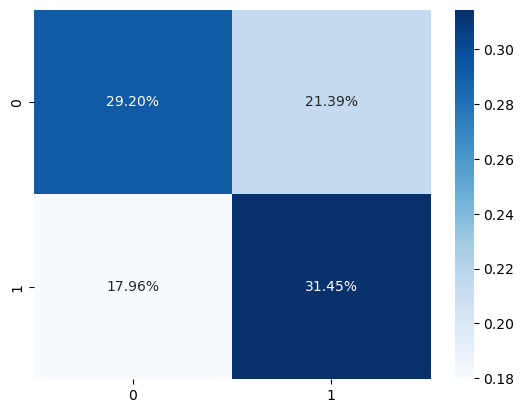

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_class = (y_pred > .5).astype(int)
matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [22]:
matrix

array([[714, 523],
       [439, 769]], dtype=int64)